In [140]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap


In [141]:
parts_data = pd.read_csv('/Users/skylerwilson/Desktop/Lighthouse_Labs/Projects/final_project/data/Project_Data/final_parts_data.csv')

In [142]:
# Clean sales data function
def clean_sales_data(df, column_names):
    for col in column_names:  
        df[col] = np.abs(df[col])
    return df

# Clean quantity data function
def clean_quantity_data(df, quantity_col):
    return df[df[quantity_col] > 0]

# Clean turnover data function
def clean_negative_data(df, turnover_col):
    return df[df[turnover_col] >= 0]


def z_score(column, threshold=2):
    z_scores = (column - column.mean()) / column.std()
    return np.abs(z_scores) < threshold

sales_data = ['Sales Last Month', 'Sales Last 3 Months', 'Sales Last 6 Months', 'Sales Last 9 Months',
              'Sales Last 12 Months', 'Sales Last 2 Years', 'Sales Last 3 Years',
              'Sales Last 4 Years', 'Sales Last 5 Years', 'Sales Last 10 Years',
              'Months No Sale', 'Reorder Point', 'Sales - Jan', 'Sales - Feb',
              'Sales - Mar', 'Sales - Apr', 'Sales - May', 'Sales - Jun',
              'Sales - Jul', 'Sales - Aug', 'Sales - Sep', 'Sales - Oct',
              'Sales - Nov', 'Sales - Dec', 'Sales - 1st Qtr', 'Sales - 2nd Qtr',
              'Sales - 3rd Qtr', 'Sales - 4th Qtr', 'Sales - This Year','Sales - Last Year']
quantity_col = 'Quantity'
turnover_col = 'Turnover'

num_cols = parts_data.select_dtypes(include='number').columns

# Apply preprocessing steps
parts_data = clean_sales_data(parts_data, sales_data)
parts_data = clean_quantity_data(parts_data, quantity_col)
parts_data = clean_negative_data(parts_data, turnover_col)


# Apply z-score transformation to numerical columns
parts_data[num_cols] = parts_data[parts_data[num_cols].apply(z_score)][num_cols]

#deals with columns that dont have data yet so they end up as NaN when they shouldnt
parts_data[num_cols] = np.where(parts_data[num_cols].isna(), 0, parts_data[num_cols])



In [143]:
# Custom transformer classes
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        transformed_data = X.copy()
        for col in self.columns:
            transformed_data[col], _ = yeojohnson(X[col] + 0.01)  # Adding 0.01 to avoid zero values
        return transformed_data

# Load and preprocess the data
y = parts_data['Customer LTV']
X = parts_data.select_dtypes(include='number').drop(columns=['Customer LTV'])
constant_columns = X.columns[X.nunique() == 1]
X.drop(columns=constant_columns, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Define columns to transform
cols_to_transform = X.columns

# Column transformer for Yeo-Johnson transformation
yeo_johnson_cols = ColumnTransformer(
    transformers=[('yeo_johnson', YeoJohnsonTransformer(columns=cols_to_transform), cols_to_transform)],
    remainder='passthrough'
)

# Create FeatureUnion combining TruncatedSVD and SelectKBest
features = FeatureUnion([
    ('svd', TruncatedSVD(n_components=5)),
    ('select_k_best', SelectKBest(score_func=f_regression, k=3))
])

# Create the final pipeline
# Create the final pipeline with best hyperparameters
final_pipeline = Pipeline([
    ('transformer', yeo_johnson_cols),
    ('features', features),
    ('scaler', RobustScaler()),
    ('regressor', XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=2,
        min_child_weight=5,
        subsample=0.5,
        gamma=0.2,
        reg_alpha=0.5,
        reg_lambda=10
    ))
])

final_pipeline.fit(X_train, y_train)

X_train_transformed = final_pipeline.named_steps['transformer'].transform(X_train)
X_train_transformed = final_pipeline.named_steps['features'].transform(X_train_transformed)
X_train_transformed = final_pipeline.named_steps['scaler'].transform(X_train_transformed)

# Transform the testing data using the pipeline
X_test_transformed = final_pipeline.named_steps['transformer'].transform(X_test)
X_test_transformed = final_pipeline.named_steps['features'].transform(X_test_transformed)
X_test_transformed = final_pipeline.named_steps['scaler'].transform(X_test_transformed)

# Predict on the transformed test data
y_pred = final_pipeline.named_steps['regressor'].predict(X_test_transformed)


In [144]:
import math
# Evaluate your model using appropriate metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

r_squared = r2_score(y_test, y_pred)
print(f'R squared Value: {r_squared}')


Mean Squared Error: 21613.734652512052
Root Mean Squared Error: 147.01610337820838
Mean Absolute Error: 44.68190598575342
R squared Value: 0.9906239545082176


In [145]:
# Get the names of the original features corresponding to selected k best features
selected_k_best_feature_names = X_train.columns[selected_k_best_indices]
print(f'1: {selected_k_best_feature_names[0]}')
print(f'2: {selected_k_best_feature_names[1]}')
print(f'3: {selected_k_best_feature_names[2]}')


1: Sales Last 3 Months
2: Months No Sale
3: Total Score


In [146]:
# Get the names of the original features corresponding to selected k best features
selected_k_best_feature_names = X_train.columns[selected_k_best_indices]

# Create interactive scatter plots for each selected feature
for feature_name in selected_k_best_feature_names:
    fig = px.scatter(x=X_train[feature_name], y=y_train, title=f'Impact of {feature_name} on Customer LTV')
    fig.update_layout(xaxis_title=feature_name, yaxis_title='Customer LTV')
    fig.show()

In [147]:
import plotly.express as px

# Create an interactive scatterplot using Plotly
fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'Actual Values (y_test)', 'y': 'Predicted Values (y_pred)'},
                 title='Actual vs. Predicted Values')
fig.update_layout(showlegend=False, template='plotly')
fig.show()


In [148]:
xgb_predict = final_pipeline.named_steps['regressor']

# Initialize the SHAP explainer using the transformed training data
explainer = shap.Explainer(xgb_predict)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_transformed, check_additivity=False)

In [149]:
shap_values.shape

(2082, 8)

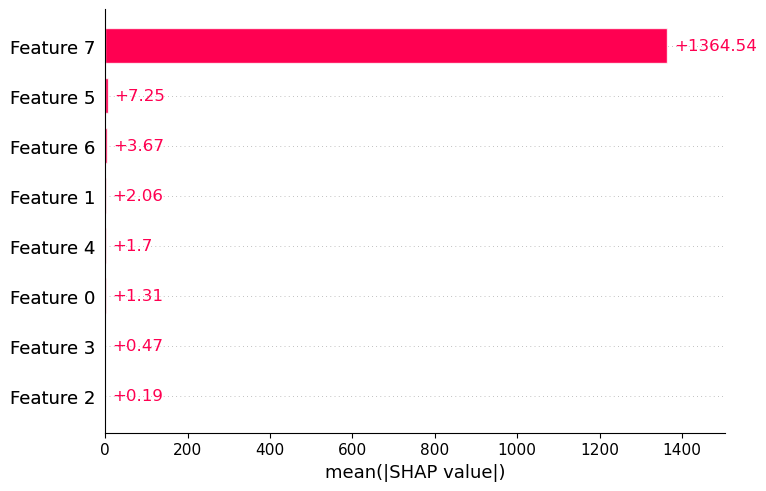

In [150]:
shap.plots.bar(shap_values, max_display=8)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/shap/plots/_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



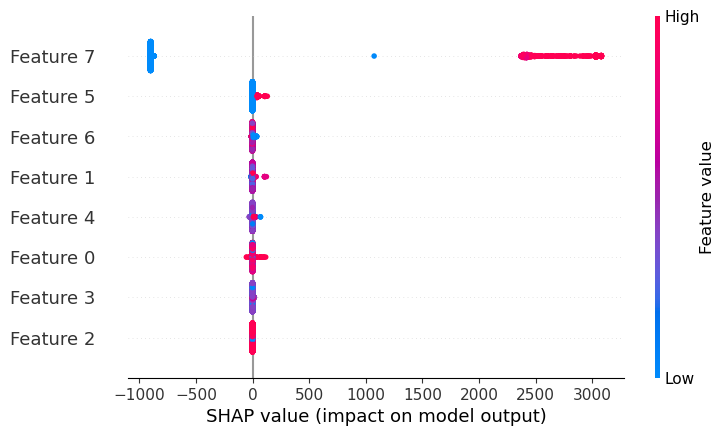

In [151]:
shap.plots.beeswarm(shap_values, max_display=8)  # Customize the color to blue
